In [1]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import vstack
from numpy.random import randint

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768, 768, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 64) 6208        concatenate[0][0]            

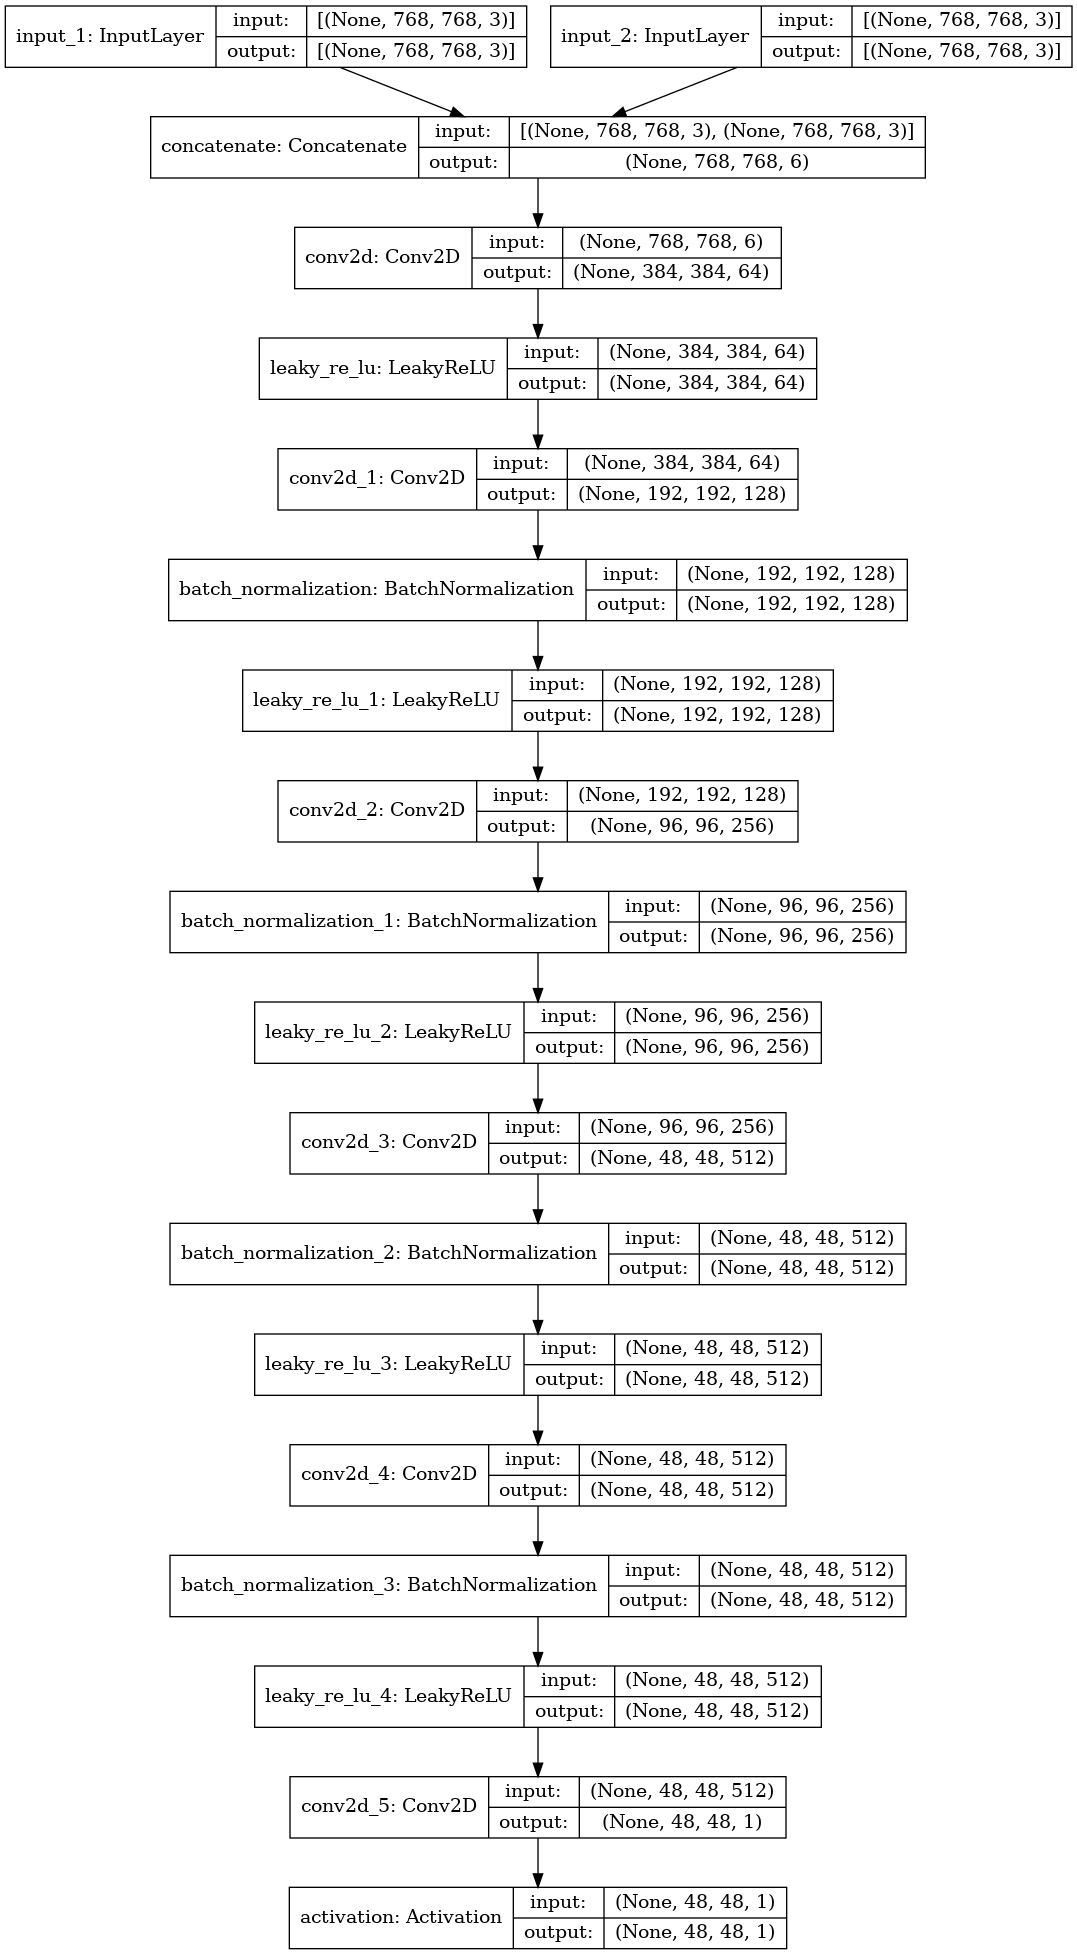

In [2]:
# example of defining a 70x70 patchgan discriminator model
from keras.utils.vis_utils import plot_model
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (768,768,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 384, 384, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 384, 384, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 192, 192, 128 131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

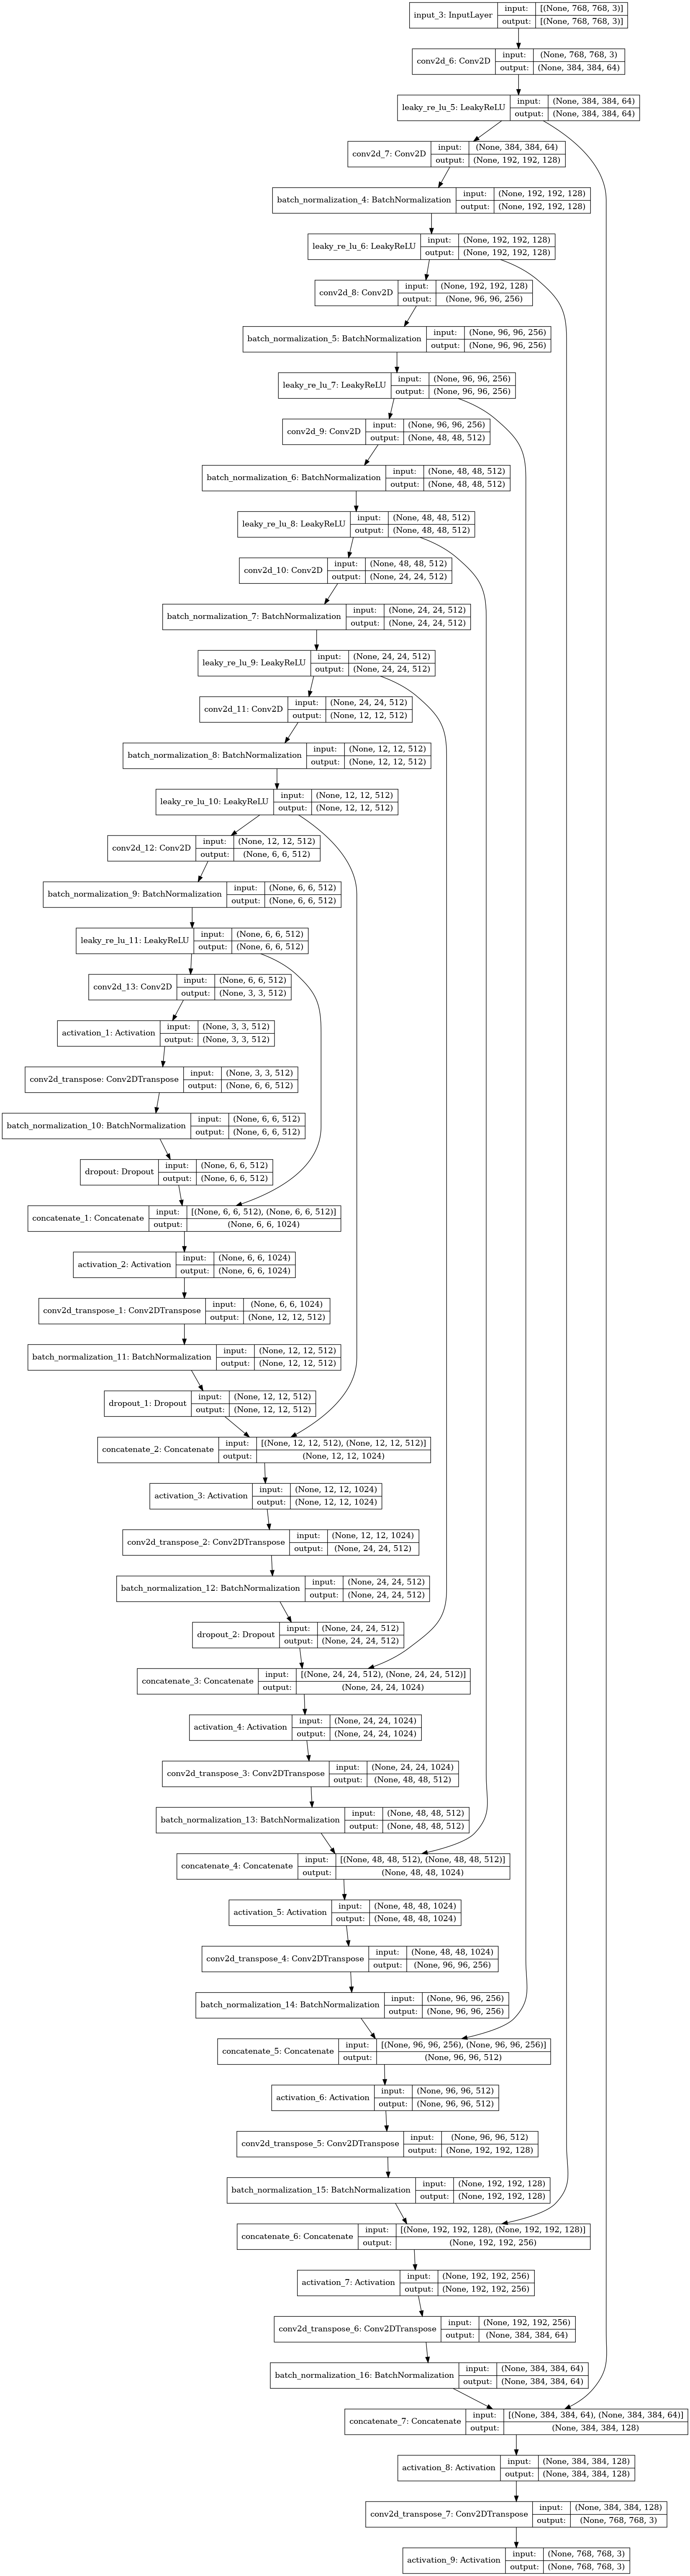

In [3]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(768,768,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define image shape
image_shape = (768,768,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 768, 768, 3)  54429315    input_7[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 48, 48, 1)    6968257     input_7[0][0]                    
                                                                 model_3[0][0]                    
Total params: 61,397,572
Trainable params: 54,422,275
Non-trainable params: 6,975,297
__________________________________________________________________________________________________


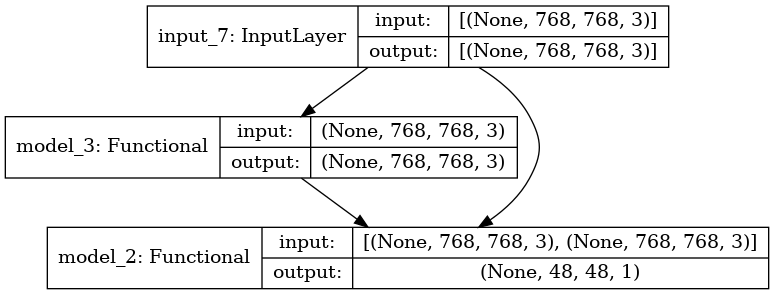

In [5]:
# define image shape
image_shape = (768,768,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [7]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [8]:
from matplotlib import pyplot
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=3, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)
	summarize_performance(i, g_model, dataset)

In [9]:
import pandas as pd
import csv
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

traincsv = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
c=[]

for i in (traincsv["EncodedPixels"].notnull()):
        if i==True:
            c.append(1)
        else:
            c.append(0)

traincsv["class"]=c

#traincsv_unique = traincsv.drop_duplicates(subset=['ImageId'], keep='first')

print(traincsv.head())
#print("\n Shape of the Dataframe:",traincsv_unique.shape)

#traincsv_unique = traincsv_unique.sort_values(by = ["class"])
#traincsv_unique.reset_index(drop = True, inplace = True)

a=traincsv.loc[traincsv['class'] == 0]
b=traincsv.loc[traincsv['class'] == 1]

# # Randomly sample 70% of your dataframe
# reduced_a = df.sample(frac=0.7)

# Randomly sample n elements from your dataframe
reduced_a = a.sample(n=50)
reduced_b = b.sample(n=250)

# traincsv_unique = pd.concat([traincsv_unique.loc[:299], traincsv_unique.loc[192356:]])

# print(traincsv_unique.head())
# print("\n Shape of the Dataframe:",traincsv_unique.shape)
# traincsv_unique.to_csv('reduced.csv')
# paths = traincsv_unique["ImageId"]
# #print(type(paths))

traincsv_unique = pd.concat([reduced_a, reduced_b]).sample(frac=1)

print(traincsv_unique.head())
print("\n Shape of the Dataframe:",traincsv_unique.shape)
#traincsv_unique.sample(frac=1)
traincsv_unique.to_csv('reduced.csv')
paths = traincsv_unique["ImageId"]
#print(type(paths))

countzero=0
countone=0
for i in (traincsv_unique["EncodedPixels"].notnull()):

    if i==True:
        c.append(1)
        countzero=countzero+1
    else:
        c.append(0)
        countone=countone+1
        
print('zero=',countzero)
print('one=',countone)

         ImageId                                      EncodedPixels  class
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
              ImageId                                      EncodedPixels  \
150623  a668fb07c.jpg  189303 2 190068 5 190834 7 191600 10 192368 10...   
18346   144cb0a00.jpg  15730 2 16498 4 17265 7 18033 10 18800 13 1956...   
105395  74150366c.jpg  196839 7 197607 7 198375 7 199143 7 199911 7 2...   
123895  88cf7aafb.jpg                                                NaN   
98686   6cc34bb44.jpg  147796 1 148563 3 149330 5 150097 7 150864 9 1...   

        class  
150623      1  
18346       1  
105395      1  
123895      0  
98686       1

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from tqdm.notebook import tqdm_notebook as tqdm
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DATA_DIR = '/kaggle/input/airbus-ship-detection'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'
count=0
# training dataset
# SEGMENTATION = DATA_DIR + '/train_ship_segmentations_v2.csv'
# anns = pd.read_csv(SEGMENTATION)
# anns.head()
from pandas import *
data = read_csv("./reduced.csv")
 
# converting column data to list
encoded_pixel_list = data['EncodedPixels'].tolist()
#print(encoded_pixel_list[2])

def extractLists(lst):
    return [[el] for el in lst]
      
    return(res)

# new_lst = list(map(int, encoded_pixel_list.split(',')))
new_lst=extractLists(encoded_pixel_list)
print(len(data))
print(len(new_lst))

del data
del encoded_pixel_list
import gc
gc.collect()

300
300


20091

In [11]:
def mask_generator(en_pix):
    if not(pd.isnull(en_pix[0])): 
        mask_img = np.zeros((768*768,1), dtype=int)
        for i in range(len(en_pix)):        
            rle = list(map(int, en_pix[i].split(' ')))
            pixel,pixel_count = [],[]
            [pixel.append(rle[i]) if i%2==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
            rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
            rle_mask_pixels = sum(rle_pixels,[]) 
            mask_img[rle_mask_pixels] = 255
    
        l,b=768,768
        size=(768,768)
        mask = np.reshape(mask_img, (b, l)).T
        im = Image.fromarray((mask * 255).astype(np.uint8))
        im.save("mask.jpg")
        
        #         pyplot.subplot(1, 2, 2)
        #         pyplot.imshow(im)
        #         pyplot.show()
        
        my_mask = load_img('mask.jpg', target_size=size)
        my_mask = img_to_array(my_mask)
    else:
        #count=count+1
        mask_img = np.zeros((768*768,1), dtype=int)
        l,b=768,768
        size=(768, 768)
        mask = np.reshape(mask_img, (b, l)).T
        im = Image.fromarray((mask * 255).astype(np.uint8))
        im.save("mask.jpg")
        #         pyplot.subplot(1, 2, 2)
        #         pyplot.imshow(im)
        #         pyplot.show()
        my_mask = load_img('mask.jpg', target_size=size)
        my_mask = img_to_array(my_mask)
    return (my_mask*255).astype('uint8')

# load all images in a directory into memory
def load_images(path, size=(768, 768)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    exclude_list = ['ImageId','6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg','d50ddd1e3.jpg'] #corrupted images
    
    # training dataset
    #SEGMENTATION = DATA_DIR + '/train_ship_segmentations_v2.csv'
    #anns = pd.read_csv(SEGMENTATION)
    #anns.head()

    #sample_mask=mask_generator(en_pix)
    i=0
    count=0
    
    with open('./reduced.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
        csv_reader = csv.reader(read_obj)
        # Iterate over each row in the csv using reader object
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            #print(row[1])
            if row[1] not in exclude_list:#['ImageId']:
                #if count==67394:
                #    break
                pixels = load_img(path + row[1], target_size=size)
                # convert to numpy array
                
                #                 pyplot.subplot(1, 2, 1)
                #                 pyplot.imshow(pixels)
                
                pixels = img_to_array(pixels)
                # split into satellite and map
                #img_list = list(map(int, encoded_pixel_list.split(',')))
                #print('ImageID= ',row[1])
                encoded_pixles = traincsv.loc[traincsv['ImageId'] == row[1], 'EncodedPixels'].tolist()
                sat_img, map_img = pixels, mask_generator(encoded_pixles)
                src_list.append(sat_img)
                tar_list.append(map_img)
                i=i+1
        #print('i=',i)
           
        
#     for filename in listdir(paths) :
#         # load and resize the image
#         if filename not in exclude_list:
#             #if count==67394:
#             #    break
#             pixels = load_img(paths[i], target_size=size)
#             # convert to numpy array
#             pixels = img_to_array(pixels)
#             # split into satellite and map
#             #img_list = list(map(int, encoded_pixel_list.split(',')))
#             sat_img, map_img, count = pixels, mask_generator(new_lst[i],count), count
#             src_list.append(sat_img)
#             tar_list.append(map_img)
#         i=i+1
    print(i)
    return [asarray(src_list), asarray(tar_list)]

300
Loaded:  (300, 768, 768, 3) (300, 768, 768, 3)
Saved dataset:  Ships.npz


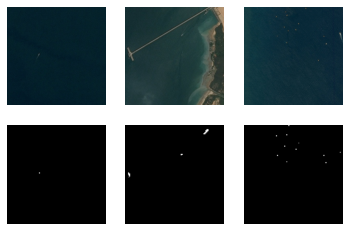

In [12]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
# dataset path
paths = traincsv_unique["ImageId"]
path = "../input/airbus-ship-detection/train_v2/"
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'Ships.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

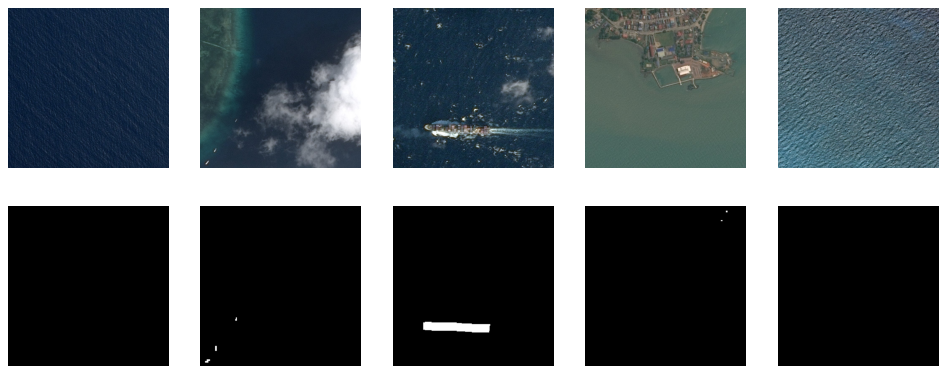

In [13]:
# plot source images
n_samples = 5
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i+20].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i+20].astype('uint8'))
pyplot.show()

# src_images[i]
# stencil = numpy.zeros(img.shape).astype(img.dtype)

In [14]:
del src_images
del tar_images
import gc
gc.collect()

38820

In [15]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [16]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
# load image data
dataset = load_real_samples('./Ships.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (300, 768, 768, 3) (300, 768, 768, 3)


In [17]:
# train model
train(d_model, g_model, gan_model, dataset)

>1, d1[0.387] d2[0.663] g[102.193]
>2, d1[0.235] d2[0.621] g[99.942]
>3, d1[0.441] d2[0.607] g[99.602]
>4, d1[0.427] d2[0.701] g[96.422]
>5, d1[0.446] d2[0.881] g[93.619]
>6, d1[0.197] d2[0.624] g[90.237]
>7, d1[0.116] d2[0.406] g[87.539]
>8, d1[0.343] d2[0.404] g[87.339]
>9, d1[0.165] d2[0.304] g[83.790]
>10, d1[0.101] d2[0.232] g[79.424]
>11, d1[0.107] d2[0.179] g[77.264]
>12, d1[0.176] d2[0.411] g[74.765]
>13, d1[0.282] d2[0.202] g[72.797]
>14, d1[0.221] d2[0.149] g[75.144]
>15, d1[0.060] d2[0.198] g[66.587]
>16, d1[0.077] d2[0.129] g[69.015]
>17, d1[0.123] d2[0.144] g[63.532]
>18, d1[0.105] d2[0.157] g[66.425]
>19, d1[0.071] d2[0.103] g[63.517]
>20, d1[0.082] d2[0.171] g[61.273]
>21, d1[0.033] d2[0.087] g[57.040]
>22, d1[0.139] d2[0.085] g[51.887]
>23, d1[0.042] d2[0.198] g[50.241]
>24, d1[0.071] d2[0.120] g[45.627]
>25, d1[0.033] d2[0.057] g[42.860]
>26, d1[0.611] d2[0.315] g[41.634]
>27, d1[0.314] d2[0.397] g[49.057]
>28, d1[0.178] d2[0.170] g[36.626]
>29, d1[0.099] d2[0.252] g[3

In [ ]:
#summarize_performance(i, g_model, dataset)

In [19]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, tar_img, gen_img):
	from matplotlib.pyplot import figure
	figure(figsize=(15, 3), dpi=80)
	images = vstack((src_img, tar_img, gen_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Input Image', 'Ground Truth', 'Predicted Image']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		if i==0:    
			pyplot.imshow(images[i])
		else:
			pyplot.imshow((images[i]*255).astype('uint8'))
		# show title
		pyplot.title(titles[i])
	pyplot.show()
 
# load dataset ki
[X1, X2] = load_real_samples('./Ships.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_000900.h5')

Loaded (300, 768, 768, 3) (300, 768, 768, 3)


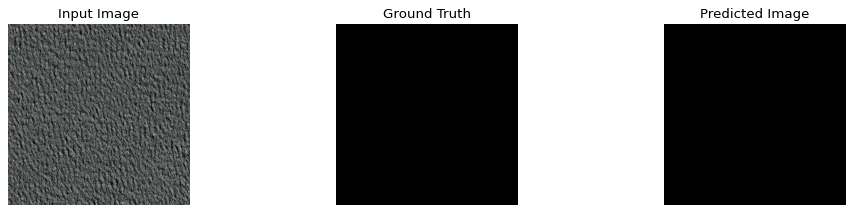

In [33]:
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, tar_image, gen_image)

In [35]:
# #src_image, tar_image = X1[ix], X2[ix]
# # generate image from source
# gen_image = model.predict('../input/airbus-ship-detection/test_v2/0010551d9.jpg')
# # plot all three images
# plot_images(src_image, tar_image, gen_image)


In [37]:
# # example of loading a pix2pix model and using it for one-off image translation
# from keras.models import load_model
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from numpy import load
# from numpy import expand_dims
# from matplotlib import pyplot

# # load an image
# def load_image(filename, size=(768,768)):
# 	# load image with the preferred size
# 	pixels = load_img(filename, target_size=size)
# 	# convert to numpy array
# 	pixels = img_to_array(pixels)
# 	# scale from [0,255] to [-1,1]
# 	pixels = (pixels - 127.5) / 127.5
# 	# reshape to 1 sample
# 	pixels = expand_dims(pixels, 0)
# 	return pixels

# # load source image
# src_image = load_image('../input/airbus-ship-detection/train_v2/000155de5.jpg')
# print('Loaded', src_image.shape)
# # load model
# model = load_model('model_025000.h5')
# # generate image from source
# gen_image = model.predict(src_image)
# # scale from [-1,1] to [0,1]
# gen_image = (gen_image + 1) / 2.0
# # plot the image
# pyplot.imshow(gen_image[0])
# pyplot.axis('off')
# pyplot.show()

In [38]:
# def plot_img(img, gen_img):
#     pyplot.figure(figsize=(15,10))
#     pyplot.subplot(1,2,1)
#     pyplot.imshow(img)
#     pyplot.title('Input Image')
#     pyplot.axis('off')
#     pyplot.subplot(1,2,2)
#     pyplot.imshow(gen_img)
#     pyplot.title('Generated Image')
#     pyplot.axis('off')

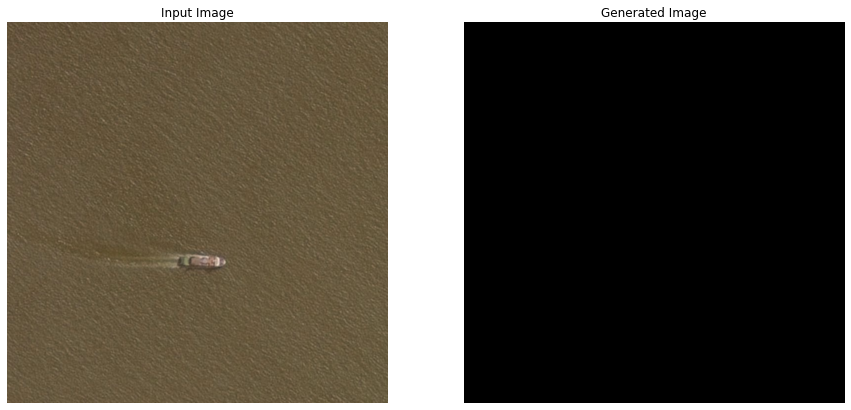

In [40]:
# import cv2
# img = cv2.imread('../input/airbus-ship-detection/train_v2/000155de5.jpg')
# img_1 = img.reshape(1,768,768,3)
# img_1 = (img_1 - 127.5) / 127.5
# gen_test_img_1 = model.predict(img_1)
# gen_test_img = gen_test_img_1.reshape(768,768,3) 
# plot_img(img,gen_test_img)